In [1]:
import os
from pathlib import Path

# Define the name of the root directory
ROOT_NAME = "EXPLib20"

# Find the root directory dynamically
current_dir = Path.cwd()
if current_dir.name == ROOT_NAME:
    root_dir = current_dir
else:
    for parent in current_dir.parents:
        if parent.name == ROOT_NAME:
            root_dir = parent
            break
    else:
        raise FileNotFoundError(f"Root directory named '{ROOT_NAME}' not found in the directory tree.")

# Change to the root directory
os.chdir(root_dir)
print(os.getcwd())

e:\RISE-OneDrive\RISE\SAFEXPLAIN-WP3 XAI - General\EXPLib20


In [48]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as T
from typing import Callable, Union, Optional, Tuple
from shap.plots import colors

from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import slic, watershed, mark_boundaries
import os
import time
from PIL import Image

In [4]:
weight_path = './EXPLib/dl_component/CNN/Object_Detectors/toy_model_v1/aikonet_toymodelv1_ssdlite.pth'
img_path = './EXPLib/datasets/Camera/toy_model_v1_inference/dev/images/rgb_0000079.png'
model_name = 'ssdlite320_mobilenet_v3_large'
num_classes = 2
im_size = 320

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [5]:
def test_slic(img_path, n_segment=50):
    img = Image.open(img_path)

    img_np = np.array(img.convert("RGB"))
    start_time = time.time()
    segments_slic = slic(img_np, n_segments=n_segment, compactness=10, sigma=1, start_label=1)
    print("segments_slic--- %s seconds ---" % (time.time() - start_time))
    start_time = time.time()
    gradient = sobel(rgb2gray(img_np))
    segments_watershed = watershed(gradient, markers=n_segment, compactness=0.001)
    print("segments_watershed--- %s seconds ---" % (time.time() - start_time))
    start_time = time.time()

    print(f'Watershed number of segments: {len(np.unique(segments_watershed))}')

    plt.imshow(mark_boundaries(img_np, segments_watershed))
    plt.title('Compact watershed')
    plt.show()

    plt.imshow(mark_boundaries(img_np, segments_slic))
    plt.title('SLIC')
    plt.show()

# test_slic(img_path)

In [45]:
def load_model(model_name="ssdlite320_mobilenet_v3_large", weight = weight_path, device = device):


    # Model definition (get model from torchvision library)
    #name = "fasterrcnn_mobilenet_v3_large_320_fpn" #[tm_v1]"ssdlite320_mobilenet_v3_large_2024Oct" #[tm_v2]fasterrcnn_mobilenet_v3_large_320_fpn
    model = torchvision.models.get_model(model_name,
                                        weights=None,
                                        weights_backbone=None,
                                        num_classes=2)

    # Load the trained model
    checkpoint = torch.load(weight_path)
    model.load_state_dict(checkpoint)
    model.to(device)


    model.eval()
    return model
toymodel = load_model(model_name="ssdlite320_mobilenet_v3_large", weight = weight_path)

def detection_model(image, model=toymodel, device=device):
    """Runs object detection and returns the max confidence score."""
    # Define the transformation for inputs
    transform = T.Compose([
            T.Resize((320, 320)),
            T.ToTensor(),
    ])
    # Ensure image is in PIL format
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)  

    # Apply transformations
    image = transform(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image)
    
    # Extract highest detection score
    if len(outputs[0]["scores"]) > 0:
        result = outputs[0]["scores"].max().unsqueeze(0)
    else:
        result = torch.tensor([0.0], device=device)

    return result.cpu().numpy()[0]  # Convert tensor to scalar NumPy value

def load_image(img_path):
    image_pil = Image.open(img_path).convert("RGB")  
    return image_pil, np.array(image_pil)  # Return both PIL and NumPy formats

# Apply SLIC segmentation
def segment_image(image_np, num_segments=50):
    return slic(image_np, n_segments=num_segments, compactness=10, sigma=1, start_label=1)

# Compute SHAP values for image regions
def compute_shap_values(
    image_np: np.ndarray,
    segments: np.ndarray,
    baseline_score: float,
    detection_model: Callable[[Image.Image], float],
    num_segments: Optional[int] = 50,
    num_samples: int = 200
) -> np.ndarray:
    """
    Compute SHAP (SHapley Additive exPlanations) values for image regions.
    
    Args:
        image_np (np.ndarray): Input image as a numpy array.
        segments (np.ndarray): Segmentation mask with integers [0, num_segments-1].
        baseline_score (float): Base detection score for the original image.
        detection_model (Callable): Function that takes a PIL Image and returns a detection score.
        num_segments (Optional[int]): Number of segments in the image. If None, computed from segments.
        num_samples (int): Number of random samples to use for SHAP computation.
    
    Returns:
        np.ndarray: SHAP values for each segment.
        
    Raises:
        ValueError: If input parameters are invalid.
        TypeError: If input types are incorrect.
    """
    # Input validation
    if not isinstance(image_np, np.ndarray):
        raise TypeError("image_np must be a numpy array")
    if not isinstance(segments, np.ndarray):
        raise TypeError("segments must be a numpy array")
    if image_np.shape[:2] != segments.shape:
        raise ValueError("image and segments shapes must match")
    
    # If num_segments is None, compute from segments
    if num_segments is None:
        num_segments = len(np.unique(segments))
    else:
        actual_segments = len(np.unique(segments))
        if actual_segments > num_segments:
            raise ValueError(f"num_segments ({num_segments}) is less than actual number of segments ({actual_segments})")
    
    # Initialize SHAP values and contribution counter
    shap_values = np.zeros(num_segments)
    contribution_count = np.zeros(num_segments)
    
    try:
        for _ in range(num_samples):
            # Create random mask (coalition)
            mask = np.random.choice([0, 1], size=num_segments, p=[0.5, 0.5])
            perturbed_image = np.copy(image_np)

            # Apply masking with vectorized operations where possible
            for i in range(num_segments):
                if mask[i] == 0:
                    segment_mask = (segments == i)
                    if segment_mask.any():  # Check if segment exists
                        # Compute mean color for each channel
                        mean_color = np.mean(image_np[segment_mask], axis=0)
                        perturbed_image[segment_mask] = mean_color

            # Compute new score
            try:
                new_score = detection_model(Image.fromarray(perturbed_image.astype('uint8')))
            except Exception as e:
                print(f"Warning: Detection model failed for sample {_}: {str(e)}")
                continue

            # Update SHAP values and count contributions
            score_diff = new_score - baseline_score
            shap_values += score_diff * mask
            contribution_count += mask

        # Normalize SHAP values by actual contribution counts
        # Add small epsilon to avoid division by zero
        epsilon = 1e-10
        normalized_shap = shap_values / (contribution_count + epsilon)
        
        return normalized_shap

    except Exception as e:
        raise RuntimeError(f"Error computing SHAP values: {str(e)}")

C:\Users\thanh\AppData\Local\Temp\ipykernel_54372\2415815815.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path)


In [46]:
# Compute baseline detection score
def compute_shap(img_path, num_segments=30):
    image_pil, image_np = load_image(img_path)
    baseline_score = detection_model(image_pil)
    # Compute SHAP values
    segments = segment_image(image_np, num_segments=num_segments)
    shap_values = compute_shap_values(image_np, segments, baseline_score, detection_model)

    # Create SHAP heatmap
    shap_map = np.zeros_like(image_np, dtype=np.float32)
    for i in range(len(shap_values)):
        shap_map[segments == i] = shap_values[i]

    shap_map_min = shap_map.min()
    shap_map_max = shap_map.max()
    shap_map_range = shap_map_max - shap_map_min
        
    if shap_map_range > 0:
        shap_map = (shap_map - shap_map_min) / shap_map_range
    else:
        # If all values are the same, set shap_map to zeros or a constant
        shap_map = np.zeros_like(shap_map)
    return shap_map, image_np

img_path = './EXPLib/datasets/Camera/toy_model_v1_inference/dev/images/rgb_0000079.png'
shap_map, image_np = compute_shap(img_path, num_segments=30)

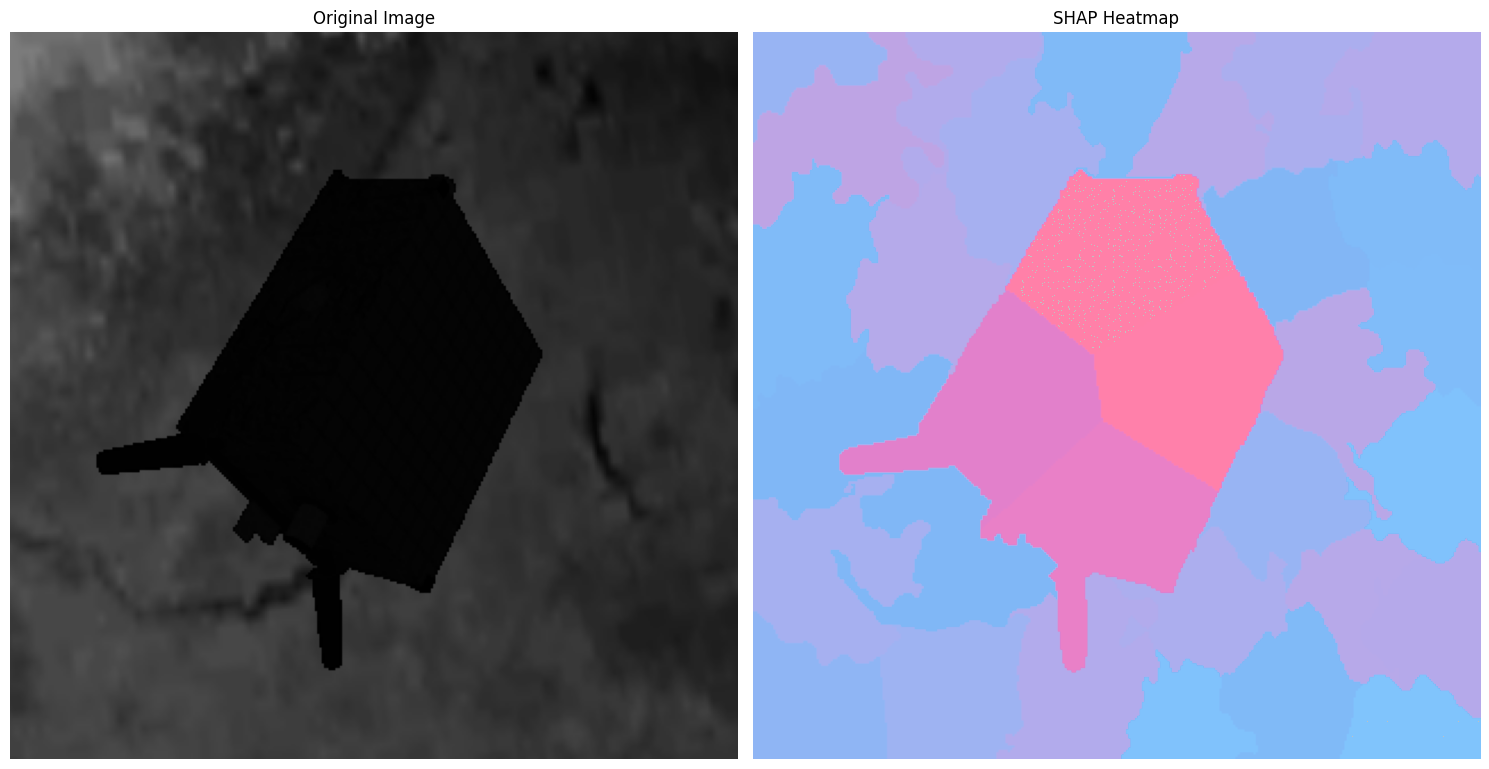

In [51]:
def plot_shap(image_np, shap_map):
    # Normalize SHAP values (if not done yet)
    shap_map = shap_map[:,:,1]

    # Create a figure and use gridspec to manage layout
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))

    # Plot the original image
    ax[0].imshow(image_np)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Overlay the SHAP heatmap on the original image
    ax[1].imshow(shap_map, cmap=colors.red_blue, alpha=0.5)  # Use 'plasma' for better color contrast
    ax[1].set_title("SHAP Heatmap")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()


plot_shap(image_np, shap_map)
